C:\Users\ime203\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ime203\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [43:38<00:00,  7.00s/it]


Epoch [1/5], Loss: 1.1473, Train Accuracy: 0.5360


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:15<00:00,  2.71s/it]


Epoch [1/5], Val Loss: 1.1344, Val Accuracy: 0.4988


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [43:22<00:00,  6.96s/it]


Epoch [2/5], Loss: 1.0115, Train Accuracy: 0.6006


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:10<00:00,  2.66s/it]


Epoch [2/5], Val Loss: 0.9318, Val Accuracy: 0.6367


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [43:26<00:00,  6.97s/it]


Epoch [3/5], Loss: 0.9095, Train Accuracy: 0.6646


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:09<00:00,  2.65s/it]


Epoch [3/5], Val Loss: 0.9369, Val Accuracy: 0.6715


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [43:39<00:00,  7.01s/it]


Epoch [4/5], Loss: 0.8246, Train Accuracy: 0.7056


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:09<00:00,  2.65s/it]


Epoch [4/5], Val Loss: 0.9225, Val Accuracy: 0.6775


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [43:12<00:00,  6.93s/it]


Epoch [5/5], Loss: 0.7734, Train Accuracy: 0.7268


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:09<00:00,  2.65s/it]


Epoch [5/5], Val Loss: 0.7778, Val Accuracy: 0.7123


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [04:10<00:00,  2.66s/it]


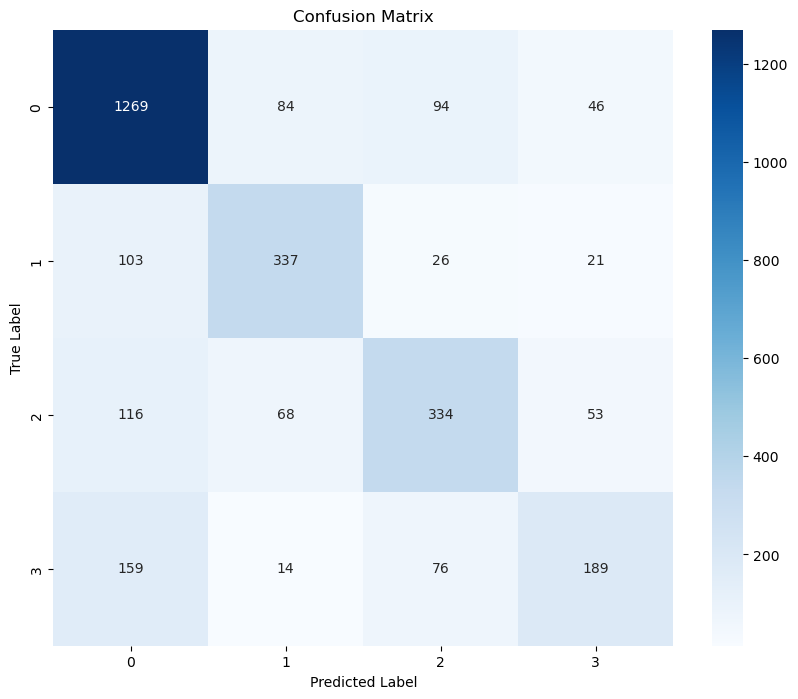

Accuracy: 0.7123
Precision: 0.7040
Recall: 0.7123
F1 Score: 0.7047


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\ime203\Downloads\yolov8n\image_labels1.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

# DenseNet121 + LSTM 모델 정의
class DenseNetLSTMClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(DenseNetLSTMClassifier, self).__init__()
        self.cnn = models.densenet121(pretrained=True)
        num_ftrs = self.cnn.classifier.in_features
        self.cnn.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, hidden_dim)
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:  # 3D CNN input (batch, seq, channel, height, width)
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:  # 2D CNN input (batch, channel, height, width)
            cnn_out = self.cnn(x)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out

# 모델 초기화
num_classes = 4  # 데이터셋에 맞게 조정
densenet_lstm_model = DenseNetLSTMClassifier(num_classes=num_classes)

# 손실 함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_lstm_model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 5
for epoch in range(num_epochs):
    densenet_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        outputs = densenet_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 검증
    densenet_lstm_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            outputs = densenet_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_running_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

# 최종 검증 및 성능 지표 계산
densenet_lstm_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        outputs = densenet_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
